In [29]:
import networkx as nx
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler
import random


In [27]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

import scipy.io
import torch
from torch_geometric.utils import from_scipy_sparse_matrix

In [9]:
#2.1
G = nx.Graph()

file_path = 'ca-AstroPh.txt'
max_lines=1500

index=0
with open(file_path, 'r') as file:
    for line in file:
        index=index+1
        if index>=1501:
            break 
        node1, node2 = map(int, line.strip().split())
        
        if G.has_edge(node1, node2):
            G[node1][node2]['weight'] += 1
        else:
            G.add_edge(node1, node2, weight=1)
            
            
# for edge in G.edges(data=True):
#     print(edge)            

In [10]:
#2.2
def compute_egonet_features(G):
    features = {}
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        egonet = G.subgraph(neighbors + [node]) 
        
        Ni = len(neighbors)
        
        Ei = len(egonet.edges())
        
        Wi = sum(data['weight'] for _, _, data in egonet.edges(data=True))
        adjacency_matrix = nx.to_numpy_array(egonet, weight='weight')
        eigenvalues = np.linalg.eigvals(adjacency_matrix)
        lambda_wi = max(eigenvalues).real  
        
        features[node] = {
            'Ni': Ni,
            'Ei': Ei,
            'Wi': Wi,
            'lambda_wi': lambda_wi
        }
    
    nx.set_node_attributes(G, features)
    
compute_egonet_features(G)

#Print the features of a node
for node, data in G.nodes(data=True):
    print(f"Node {node}: {data}")


Node 84424: {'Ni': 75, 'Ei': 84, 'Wi': 87, 'lambda_wi': np.float64(9.452271536378065)}
Node 276: {'Ni': 1, 'Ei': 1, 'Wi': 1, 'lambda_wi': np.float64(1.0)}
Node 1662: {'Ni': 1, 'Ei': 1, 'Wi': 1, 'lambda_wi': np.float64(1.0)}
Node 5089: {'Ni': 1, 'Ei': 1, 'Wi': 1, 'lambda_wi': np.float64(1.0)}
Node 6058: {'Ni': 2, 'Ei': 2, 'Wi': 2, 'lambda_wi': np.float64(1.414213562373095)}
Node 6229: {'Ni': 1, 'Ei': 1, 'Wi': 1, 'lambda_wi': np.float64(1.0)}
Node 10639: {'Ni': 1, 'Ei': 1, 'Wi': 1, 'lambda_wi': np.float64(1.0)}
Node 16442: {'Ni': 1, 'Ei': 1, 'Wi': 1, 'lambda_wi': np.float64(1.0)}
Node 19325: {'Ni': 1, 'Ei': 1, 'Wi': 1, 'lambda_wi': np.float64(1.0)}
Node 19834: {'Ni': 1, 'Ei': 1, 'Wi': 1, 'lambda_wi': np.float64(1.0)}
Node 20113: {'Ni': 1, 'Ei': 1, 'Wi': 1, 'lambda_wi': np.float64(1.0)}
Node 21937: {'Ni': 3, 'Ei': 5, 'Wi': 7, 'lambda_wi': np.float64(3.6334252644897)}
Node 25452: {'Ni': 1, 'Ei': 1, 'Wi': 1, 'lambda_wi': np.float64(1.0)}
Node 26902: {'Ni': 1, 'Ei': 1, 'Wi': 1, 'lambda_wi': 

In [11]:
#2.3   

def compute_anomaly_scores(G):
    data = []
    for node in G.nodes():
        Ni = G.nodes[node]['Ni']
        Ei = G.nodes[node]['Ei']
        data.append((Ni, Ei))
    
    data = np.array(data)
    Ni_values = data[:, 0]  # N_i
    Ei_values = data[:, 1]  # E_i
    
    log_Ni = np.log(Ni_values + 1)  
    log_Ei = np.log(Ei_values + 1)
    
    reg = LinearRegression()
    log_Ni_reshaped = log_Ni.reshape(-1, 1)
    reg.fit(log_Ni_reshaped, log_Ei)
    
    log_C = reg.intercept_  
    theta = reg.coef_[0]    
    C = np.exp(log_C)  
    
    predicted_log_Ei = reg.predict(log_Ni_reshaped)
    predicted_Ei = np.exp(predicted_log_Ei)  
    
    scores = {}
    for i, node in enumerate(G.nodes()):
        actual_Ei = Ei_values[i]
        predicted_Ei_i = predicted_Ei[i]
        
        max_val = max(actual_Ei, predicted_Ei_i)
        min_val = min(actual_Ei, predicted_Ei_i)
        score = (max_val / min_val) * np.log(abs(actual_Ei - predicted_Ei_i) + 1)
        
        scores[node] = score
    
    nx.set_node_attributes(G, scores, 'anomaly_score')

compute_anomaly_scores(G)

# Print the anomaly scores
for node, data in G.nodes(data=True):
    print(f"Node {node}: Anomaly Score = {data['anomaly_score']}")



Node 84424: Anomaly Score = 7.008985859840532
Node 276: Anomaly Score = 1.533525123954327
Node 1662: Anomaly Score = 1.533525123954327
Node 5089: Anomaly Score = 1.533525123954327
Node 6058: Anomaly Score = 1.42298944840789
Node 6229: Anomaly Score = 1.533525123954327
Node 10639: Anomaly Score = 1.533525123954327
Node 16442: Anomaly Score = 1.533525123954327
Node 19325: Anomaly Score = 1.533525123954327
Node 19834: Anomaly Score = 1.533525123954327
Node 20113: Anomaly Score = 1.533525123954327
Node 21937: Anomaly Score = 0.30415702787320614
Node 25452: Anomaly Score = 1.533525123954327
Node 26902: Anomaly Score = 1.533525123954327
Node 29829: Anomaly Score = 1.533525123954327
Node 30222: Anomaly Score = 1.533525123954327
Node 32432: Anomaly Score = 0.5998369199322191
Node 33040: Anomaly Score = 1.533525123954327
Node 39238: Anomaly Score = 1.533525123954327
Node 39521: Anomaly Score = 1.42298944840789
Node 41418: Anomaly Score = 1.533525123954327
Node 45009: Anomaly Score = 1.533525123

In [12]:
#2.4
def plot_draw(text):
    sorted_nodes = sorted(G.nodes(data=True), key=lambda x: x[1][text], reverse=True)
    top_10_nodes = [node for node, _ in sorted_nodes[:10]]
    node_colors = []
    for node in G.nodes():
        if node in top_10_nodes:
            node_colors.append('red') 
        else:
            node_colors.append('blue')

    plt.figure(figsize=(10, 10))
    nx.draw(
        G,
        node_color=node_colors,
        with_labels=False,
        node_size=50,
        edge_color='gray',
        alpha=0.7
    )
    plt.title("Graph with Top 10 Anomaly Scores Highlighted")
    plt.show()

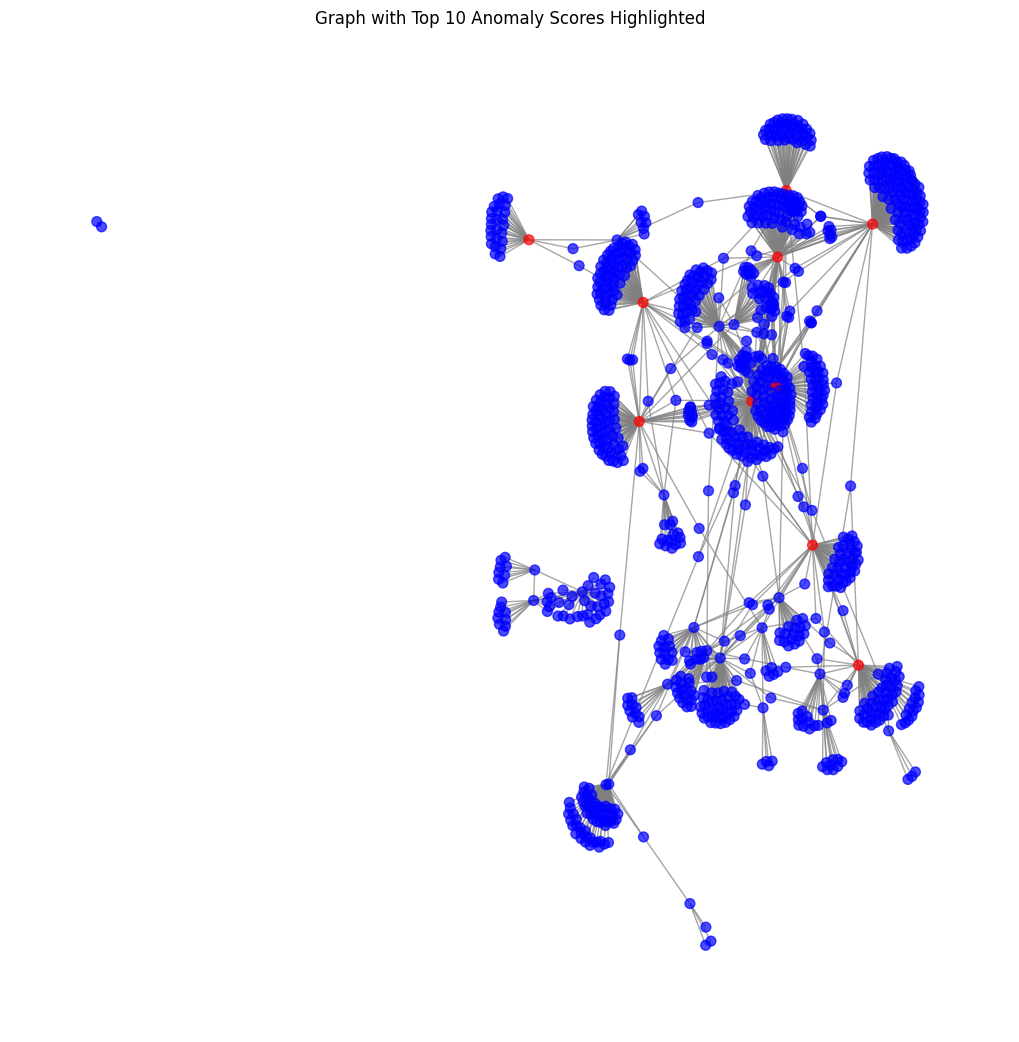

In [13]:
plot_draw('anomaly_score')

/usr/local/lib/python3.10/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


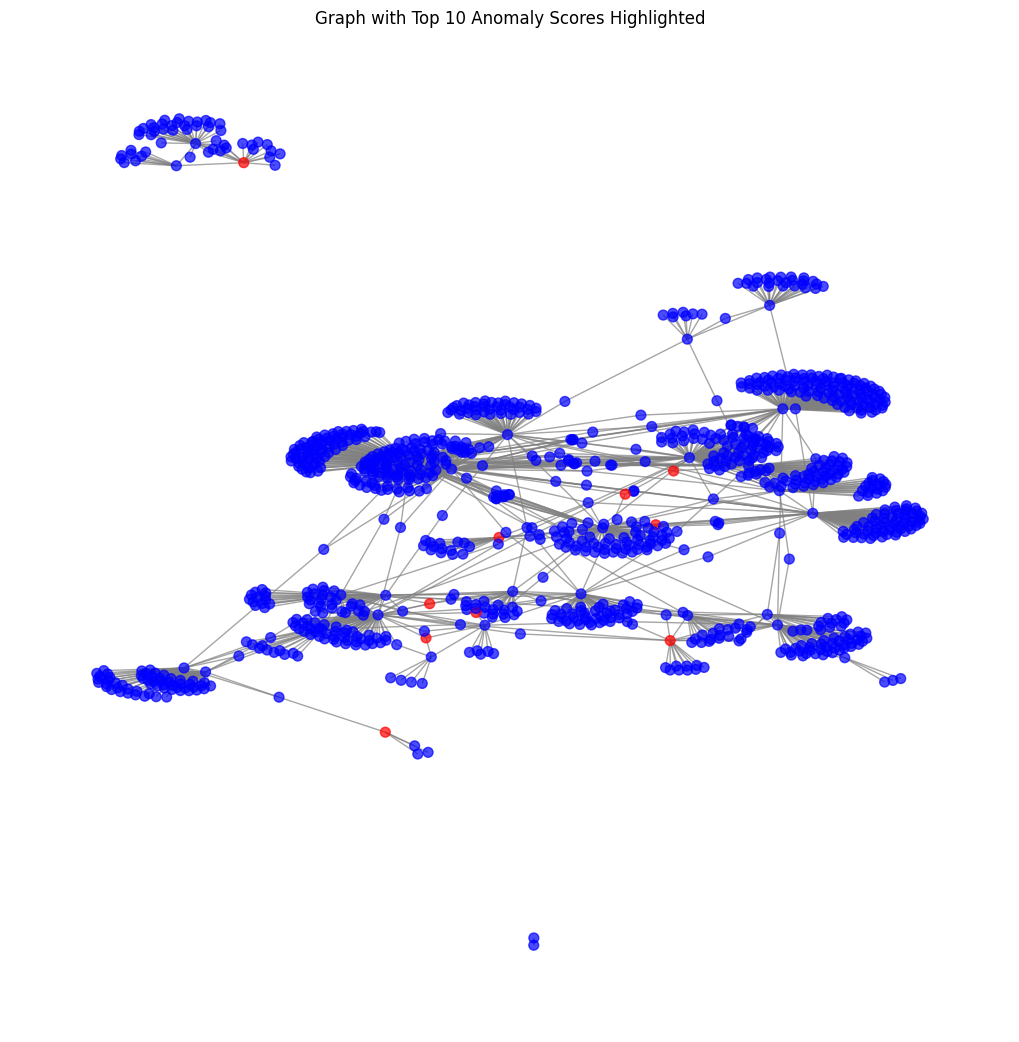

In [14]:
#2.5
def compute_combined_anomaly_scores(G):
    data = []
    for node in G.nodes():
        Ni = G.nodes[node]['Ni']
        Ei = G.nodes[node]['Ei']
        data.append((Ni, Ei))
    
    data = np.array(data)
    
    anomaly_scores = np.array([G.nodes[node]['anomaly_score'] for node in G.nodes()])
    scaler = MinMaxScaler()
    normalized_anomaly_scores = scaler.fit_transform(anomaly_scores.reshape(-1, 1)).flatten()

    lof = LocalOutlierFactor(n_neighbors=20, metric='euclidean')
    lof_scores = -lof.fit_predict(data)
    lof_scores = -lof.negative_outlier_factor_

    combined_scores = normalized_anomaly_scores + lof_scores

    for i, node in enumerate(G.nodes()):
        G.nodes[node]['combined_score'] = combined_scores[i]
        
compute_combined_anomaly_scores(G)        
        
        
plot_draw('combined_score')      
        
        

{'G1-0': np.float64(0.0827209789066222), 'G1-1': np.float64(0.8484691508634452), 'G1-2': np.float64(0.9378444623882037), 'G1-3': np.float64(0.8484691508634452), 'G1-4': np.float64(0.8484691508634452), 'G1-5': np.float64(0.8484691508634452), 'G1-6': np.float64(0.8484691508634452), 'G1-7': np.float64(2.182135899740504), 'G1-8': np.float64(2.182135899740504), 'G1-9': np.float64(0.8484691508634452), 'G1-10': np.float64(2.182135899740504), 'G1-11': np.float64(2.182135899740504), 'G1-12': np.float64(0.8484691508634452), 'G1-13': np.float64(0.8484691508634452), 'G1-14': np.float64(0.0827209789066222), 'G1-15': np.float64(0.8484691508634452), 'G1-16': np.float64(3.8316244768127623), 'G1-17': np.float64(0.8484691508634452), 'G1-18': np.float64(0.8484691508634452), 'G1-19': np.float64(0.8484691508634452), 'G1-20': np.float64(0.8484691508634452), 'G1-21': np.float64(0.8484691508634452), 'G1-22': np.float64(0.8484691508634452), 'G1-23': np.float64(0.8484691508634452), 'G1-24': np.float64(0.8484691

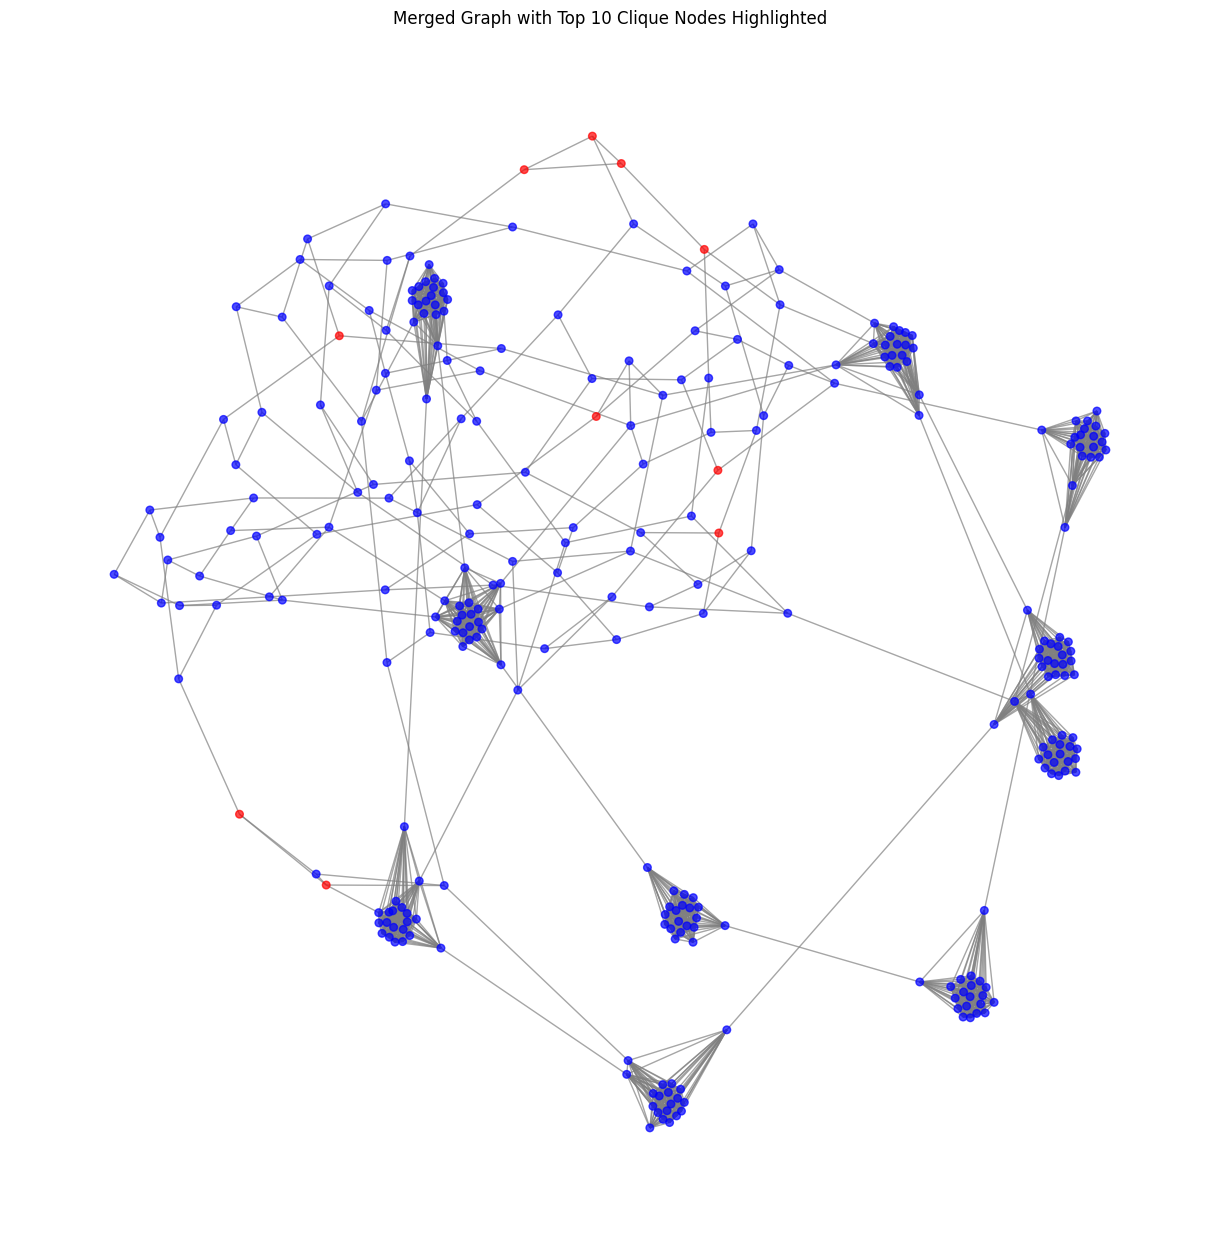

In [18]:
#3.1 Antreneaza cu NI si EI
regular_graph = nx.random_regular_graph(3, 100)

clique_graph = nx.connected_caveman_graph(10, 20)

merged_graph = nx.union(regular_graph, clique_graph, rename=('G1-', 'G2-'))

nodes_g1 = [node for node in merged_graph.nodes if str(node).startswith('G1-')]
nodes_g2 = [node for node in merged_graph.nodes if str(node).startswith('G2-')]

for _ in range(15): 
    node_g1 = random.choice(nodes_g1)
    node_g2 = random.choice(nodes_g2)
    merged_graph.add_edge(node_g1, node_g2)
        

def compute_egonet_features_ni_ei(G):
    features = {}
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        egonet = G.subgraph(neighbors + [node]) 
        
        Ni = len(neighbors)
        
        Ei = len(egonet.edges())
        
        features[node] = {
            'Ni': Ni,
            'Ei': Ei
        }
    
    nx.set_node_attributes(G, features)


compute_egonet_features_ni_ei(merged_graph)


def detect_clique_nodes(G):
        compute_anomaly_scores(G)
        anomaly_scores = nx.get_node_attributes(G, 'anomaly_score')

        sorted_nodes = sorted(anomaly_scores.items(), key=lambda x: x[1])

        top_10_nodes = [node for node, score in sorted_nodes[:10]]
    
        return top_10_nodes
    
top_10_clique_nodes=detect_clique_nodes (merged_graph) 
    

def draw_merged_graph(G, top_nodes):
    node_colors = []
    for node in G.nodes():
        if node in top_nodes:
            node_colors.append('red') 
        else:
            node_colors.append('blue')  

    plt.figure(figsize=(12, 12))
    nx.draw(
        G,
        node_color=node_colors,
        with_labels=False,
        node_size=30,
        edge_color='gray',
        alpha=0.7
    )
    plt.title("Merged Graph with Top 10 Clique Nodes Highlighted")
    plt.show()

draw_merged_graph(merged_graph, top_10_clique_nodes)


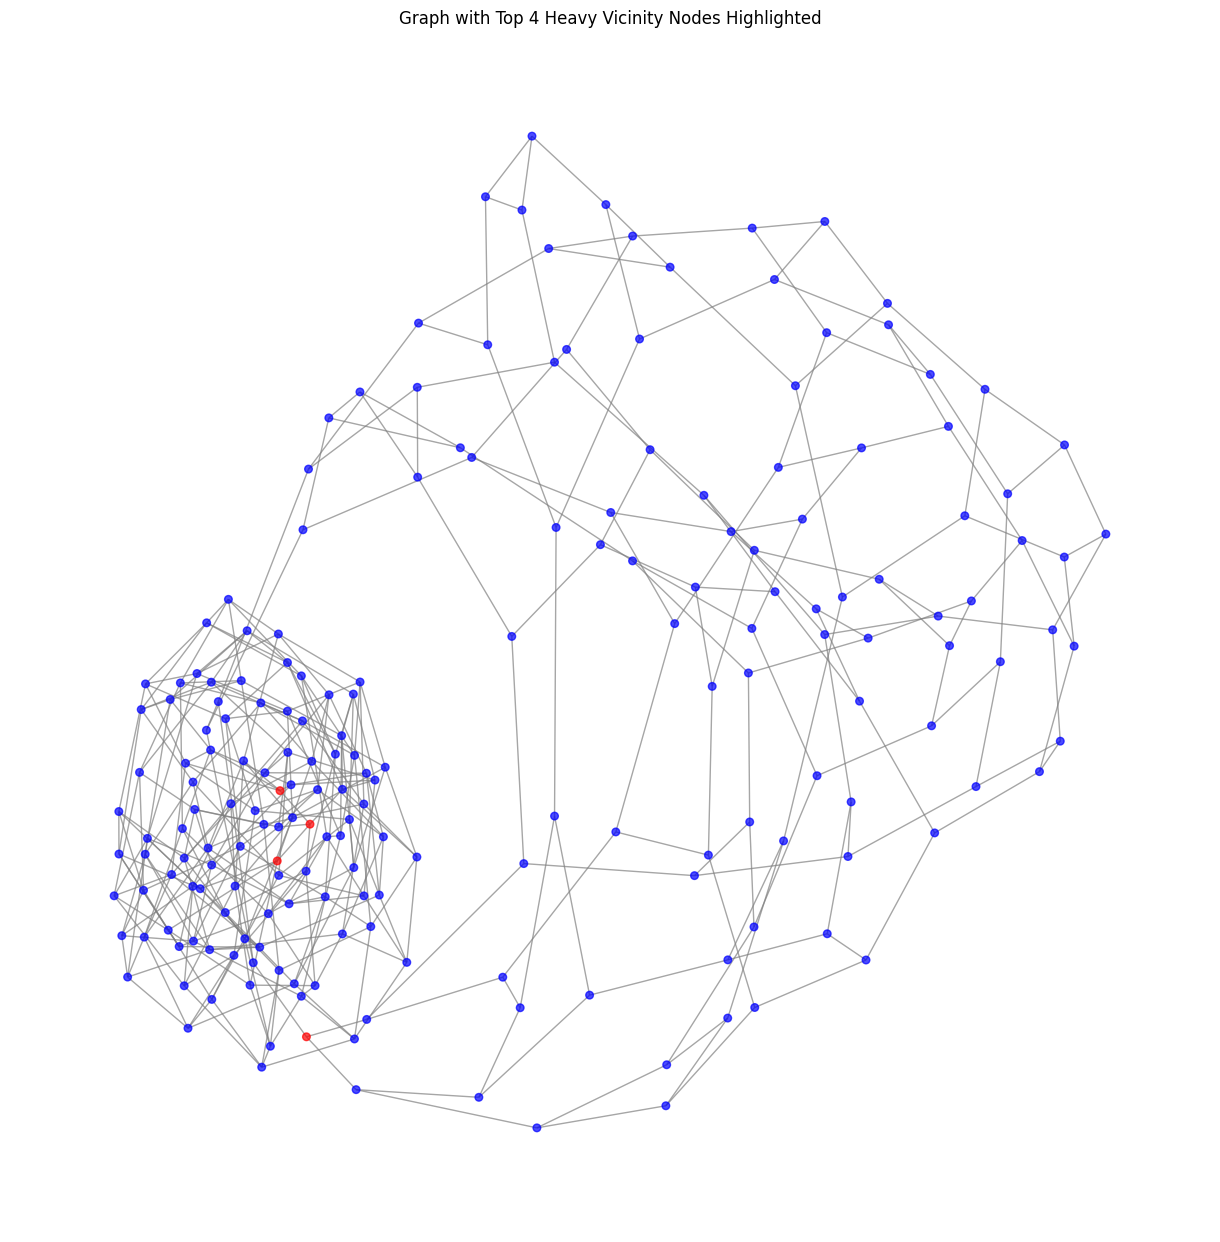

In [19]:
#3.2 Antreneaza cu WI si EI
graph1 = nx.random_regular_graph(3, 100)
graph2 = nx.random_regular_graph(5, 100)

merged_graph = nx.union(graph1, graph2, rename=('G1-', 'G2-'))

for edge in merged_graph.edges():
    merged_graph.add_edge(edge[0], edge[1], weight=1)

random_nodes = random.sample(list(merged_graph.nodes()), 2)
for node in random_nodes:
    egonet = merged_graph.subgraph(list(merged_graph.neighbors(node)) + [node])
    for u, v in egonet.edges():
        merged_graph[u][v]['weight'] += 10
        
compute_egonet_features(merged_graph)

def detect_heavy_vicinity_anomalies(G):
    scores = {}
    for node in G.nodes():
        Wi = G.nodes[node]['Wi']
        Ei = G.nodes[node]['Ei']
        scores[node] = Wi + Ei 

    sorted_nodes = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return [node for node, score in sorted_nodes[:4]]  # Top 4 nodes

top_4_nodes = detect_heavy_vicinity_anomalies(merged_graph)    




def draw_heavy_vicinity_graph(G, top_nodes):
    node_colors = []
    for node in G.nodes():
        if node in top_nodes:
            node_colors.append('red') 
        else:
            node_colors.append('blue') 

    plt.figure(figsize=(12, 12))
    nx.draw(
        G,
        node_color=node_colors,
        with_labels=False,
        node_size=30,
        edge_color='gray',
        alpha=0.7
    )
    plt.title("Graph with Top 4 Heavy Vicinity Nodes Highlighted")
    plt.show()    
        
draw_heavy_vicinity_graph(merged_graph, top_4_nodes)
       

In [26]:
#4.1
class GAE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(GAE, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, latent_dim)
        self.attr_decoder = torch.nn.Linear(latent_dim, input_dim)
        self.adj_decoder = torch.nn.Linear(latent_dim, latent_dim)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        z = self.conv2(x, edge_index)
        return z

    def decode_attributes(self, z):
        return self.attr_decoder(z)

    def decode_adjacency(self, z):
        return torch.sigmoid(torch.matmul(z, z.T))

    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        x_reconstructed = self.decode_attributes(z)
        adj_reconstructed = self.decode_adjacency(z)
        return x_reconstructed, adj_reconstructed, z

def train(model, data, optimizer, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        x_reconstructed, adj_reconstructed, _ = model(data.x, data.edge_index)
        attr_loss = F.mse_loss(x_reconstructed, data.x)
        adj_loss = F.binary_cross_entropy(adj_reconstructed, data.adj.to_dense())
        loss = attr_loss + adj_loss
        loss.backward()
        optimizer.step()

def rank_anomalous_nodes(model, data):
    model.eval()
    with torch.no_grad():
        x_reconstructed, adj_reconstructed, _ = model(data.x, data.edge_index)
        attr_error = torch.norm(data.x - x_reconstructed, dim=1)
        adj_error = torch.norm(data.adj.to_dense() - adj_reconstructed, dim=1)
        anomaly_scores = attr_error + adj_error
        ranked_nodes = torch.argsort(anomaly_scores, descending=True).tolist()
    return ranked_nodes

In [ ]:

#4.2
data = scipy.io.loadmat('ACM.mat')
print(data.keys())
attributes = torch.tensor(data['Attributes'].toarray(), dtype=torch.float32)  # Node attributes
print(attributes.shape)
adjacency_matrix = data['Network']  # Adjacency matrix (sparse)
print(adjacency_matrix.shape)

labels = torch.tensor(data['Label'].flatten(), dtype=torch.long)  # Node labels
print(labels.shape)


adjacency_matrix = adjacency_matrix.tocoo()
edge_index, edge_weight = from_scipy_sparse_matrix(adjacency_matrix)

print("Attributes shape:", attributes.shape)
print("Edge index shape:", edge_index.shape)
print("Labels shape:", labels.shape)